# Exploratory Data Analysis

# A. Environment Setup

## A.1 Import Libraries

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np
import nltk
import h5py

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import math
import io
import os
import zipfile
import time

# Suppress new window for plots
%matplotlib inline 

In [0]:
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from pprint import pprint
from collections import Counter

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8795488071055213190, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12956397377796923340
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5632476981584062659
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13009178872227323107
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## A.2 Global Variables

In [0]:
path_to_data = "/content/drive/My Drive/Colab Notebooks/W266 Final Project/data/"

# B. Functions

In [0]:
def plot_cm(y_true, y_pred, figsize=(10,8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    fig, ax = plt.subplots(figsize=figsize)
    colormap = sns.diverging_palette(220, 20, sep=20, as_cmap=True) #plt.cm.coolwarm #coolwarm_r reverse
    sns.heatmap(cm, 
                cmap=colormap, 
                annot=annot, 
                annot_kws={"size": 12}, 
                fmt='',
                linewidths=1, 
                square=True, 
                ax=ax)
    ax.set_title('Confusion Matrix\n\n', fontsize=14); 
    ax.set_xlabel('\n\nPredicted Label', fontsize=12);
    ax.set_ylabel('Actual Label\n\n', fontsize=12);

In [0]:
## TODO: ENHANCE THIS PLOT
def plot_metrics(history, model, figsize=(8,6)):
  metrics =  model.metrics_names
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history[metric],linestyle="--", label='Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

In [0]:
def plt_density_hist(data_element, title_xaxis):
  # Density plot and histogram
  bin_count = 15
  x = data_element
  x_mu = x.mean()
  x_std = x.std()
  chart_title = "Density and Histogram for " + title_xaxis
  chart_xax = title_xaxis
  chart_yax = "Frequency/Density"

  sns.distplot(x, 
              hist=True, 
              kde=True, 
              bins=bin_count, 
              color = 'darkblue', 
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 4})

  plt.title(chart_title, fontsize=14)
  plt.xlabel(chart_xax, fontsize=12)
  plt.ylabel(chart_yax, fontsize=12)

  x_norm = np.random.normal(loc = x_mu, scale = x_std, size = 5000)
  sns.kdeplot(x_norm, color="yellow", shade = True)

  plt.show()
  return

# C. Import Pre-Processed Dataset

In [0]:
print(os.getcwd())

/content


In [0]:
path_to_data = "/content/drive/My Drive/Colab Notebooks/W266 Final Project/data/"
filename = "ticket_data_pp.csv"

In [0]:
start = time.time()
ticket_data = pd.read_csv(path_to_data + filename, dtype = {'Notes': str})
ticket_data.Notes = ticket_data.Notes.fillna(' ')
end = time.time()
print("Loaded File:", (end - start))

Loaded File: 0.8833181858062744


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
ticket_data.head(5)

,Unnamed: 0,BugActionID,BugID,ActionUserID,ActionTime,AssignedID,Notes,StatusID,PriorityID,BAContactID,UpdateType,ResolutionID,ClientTouched,CodeChanged,ClientEmailed,ClientPhoned,UserDepartment,UserPosition,NextBugActionID,LastTouchPrevToCloseID,OpenAfterCloseID,NextCloseConfirmedID,RawHours,BusinessHours,LastCloseID,ActionOrder,RedirectStatus,Title,Directory,ProductID,ReportedID,Description,compid,contactid,Originated,KBArticleID,CurrentResolutionID,OpenedTime,LastBugActionID,WasLow,WasAssignedToDev,LastBugActionStatus,NumBugActions,LastContact,WasEscalatedPastRepLevel,WorkspaceID,Summary,ClientTemp,MajorityPriorityID,SupportFailbyDev,SupportFailConfirm,Classification,HighestPriorityID,owner,IsEFP,LastRedirectStatus,ChangeDateTime,HistorySummary,HistoryClientTemp,UserID,ClosestBugActionID,ArticleID,KBTitle,NumUses,NumTimesEscalated,DefaultPriorityID,PackageID,KBProductID,Active,UserFriendlyDesc,SalesProductGroupID,DefaultClassification,PriorityID_Int,clean_notes,tokenized_notes,trunc_tokenized_notes,note_length_notrunc,note_length_trunc
0,0,3486141,505111,TaxServiceSupport,2019-12-01 09:56:38.470000000,TaxServiceSupport,(Created),Open,Normal,41190.0,Opened,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3486142.0,NaN,NaN,NaN,0.0000,0.0000,NaN,1,NaN,EFP: Submission hung or stalling,NaN,NaN,TaxServiceSupport,Error in EFP,3701,41190,NaN,1545,0.0,2019-12-01 14:56:37.973000000,3486423,False,True,Closed,5,2019-12-02 10:14:47.060000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Not Support Related,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1545,EFP: Submission hung or stalling,0,0,High,-1,40,0,NaN,30,NaN,1,created,['created'],['created'],1,1
1,1,3486142,505111,TaxServiceSupport,2019-12-01 09:56:41.313000000,Tax Service Support,**EFP-Auto-Ticket-Action** Error while handli...,In Progress,Normal,41190.0,Working,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3486361.0,NaN,NaN,NaN,23.8833,0.8167,NaN,2,NaN,EFP: Submission hung or stalling,NaN,NaN,TaxServiceSupport,Error in EFP,3701,41190,NaN,1545,0.0,2019-12-01 14:56:37.973000000,3486423,False,True,Closed,5,2019-12-02 10:14:47.060000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Not Support Related,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1545,EFP: Submission hung or stalling,0,0,High,-1,40,0,NaN,30,NaN,1,efp auto ticket action error while handli...,"['efp', 'auto', 'ticket', 'action', 'error', '...","['efp', 'auto', 'ticket', 'action', 'error', '...",347,347
2,2,3486361,505111,jbaughn,2019-12-02 09:49:36.447000000,TFC/PTS Development,this seems to be stuck on submitting,In Progress,Normal,41190.0,Redirected,0.0,False,False,False,False,Payroll Tax Service,Tax Service Support Manager,3486397.0,NaN,NaN,NaN,0.2000,0.2000,NaN,3,NaN,EFP: Submission hung or stalling,NaN,NaN,TaxServiceSupport,Error in EFP,3701,41190,NaN,1545,0.0,2019-12-01 14:56:37.973000000,3486423,False,True,Closed,5,2019-12-02 10:14:47.060000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Not Support Related,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1545,EFP: Submission hung or stalling,0,0,High,-1,40,0,NaN,30,NaN,1,this seems to be stuck on submitting,"['this', 'seems', 'to', 'be', 'stuck', 'on', '...","['this', 'seems', 'to', 'be', 'stuck', 'on', '...",7,7
3,3,3486397,505111,aking,2019-12-02 10:01:27.193000000,jbaughn,submitted 270973601625361,Fixed,Normal,41190.0,Fixed,0.0,False,False,False,False,Development,Development Technician 3,3486423.0,NaN,NaN,NaN,0.2167,0.2167,NaN,4,NaN,EFP: Submission hung or stalling,NaN,NaN,TaxServiceSupport,Error in EFP,3701,41190,NaN,1545,0.0,2019-12-01 14:56:37.973000000,3486423,False,True,Closed,5,2019-12-02 10:14:47.060000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Not Support Related,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1545,EFP: Submission hung or stalling,0,0,High,-1,40,0,NaN,30,NaN,1,submitted,['submitted'],['submitted'],1,1
4,4,3486423,505111,jbaughn,2019-12-02 10:14:47.060000000,jbaughn,closing,Closed,Normal,41190.0,Worked,0.0,True,False,True,False,Payroll Tax Service,Tax Service Support Manager,NaN,3486397.0,NaN,NaN,NaN,NaN,3486423.0,5,NaN,EFP: Submission hung or stalling,NaN

In [0]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28341 entries, 0 to 28340
Data columns (total 78 columns):
Unnamed: 0                  28341 non-null int64
BugActionID                 28341 non-null int64
BugID                       28341 non-null int64
ActionUserID                28341 non-null object
ActionTime                  28341 non-null object
AssignedID                  28341 non-null object
Notes                       28341 non-null object
StatusID                    28341 non-null object
PriorityID                  28341 non-null object
BAContactID                 26734 non-null float64
UpdateType                  26727 non-null object
ResolutionID                24412 non-null float64
ClientTouched               22000 non-null object
CodeChanged                 20338 non-null object
ClientEmailed               20338 non-null object
ClientPhoned                20338 non-null object
UserDepartment              21757 non-null object
UserPosition                22967 non-null

In [0]:
# count the number of empty notes
count_empty = 0
for i in range(0, len(ticket_data['Notes'])):
  note = ticket_data['Notes'][i].strip()
  if len(note) == 0:
    count_empty += 1
  
print("Number of Blank Notes", count_empty)
print("Blank Note %:", count_empty / len(ticket_data['Notes']))

Number of Blank Notes 1860
Blank Note %: 0.06562930030697577


In [0]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28341 entries, 0 to 28340
Data columns (total 78 columns):
Unnamed: 0                  28341 non-null int64
BugActionID                 28341 non-null int64
BugID                       28341 non-null int64
ActionUserID                28341 non-null object
ActionTime                  28341 non-null object
AssignedID                  28341 non-null object
Notes                       28341 non-null object
StatusID                    28341 non-null object
PriorityID                  28341 non-null object
BAContactID                 26734 non-null float64
UpdateType                  26727 non-null object
ResolutionID                24412 non-null float64
ClientTouched               22000 non-null object
CodeChanged                 20338 non-null object
ClientEmailed               20338 non-null object
ClientPhoned                20338 non-null object
UserDepartment              21757 non-null object
UserPosition                22967 non-null

# D. EDA

**REVISIT** once we finalize the the BERT connection

* The tokens should be based on the BERT tokenization process

## D.1 Note Lengths



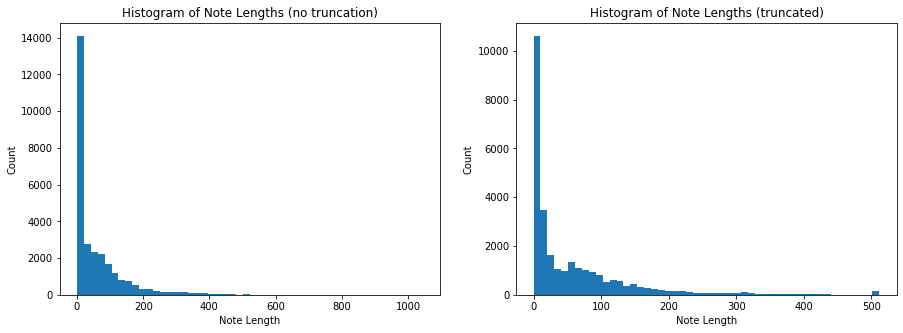

In [0]:
#plot histograms of note lengths
plt.figure(figsize =(15,5))
plt.subplot(121)
plt.hist(ticket_data['note_length_notrunc'], bins = 50)
plt.ylabel('Count')
plt.xlabel('Note Length')
plt.title('Histogram of Note Lengths (no truncation)')

#truncated notes
plt.subplot(122)
plt.hist(ticket_data['note_length_trunc'], bins = 50)
plt.ylabel('Count')
plt.xlabel('Note Length')
plt.title('Histogram of Note Lengths (truncated)')
plt.show()

In [0]:
##calculate the fraction of the notes than are greater than our chosen threshold.
#(ticket_data.note_length_notrunc.values > length_threshold).sum()/len(ticket_data.index)

In [0]:
# What is the fraction of notes that are 0 in length? We may want to drop these as it would be impossible to predict?
(ticket_data.note_length_notrunc.values == 0).sum()/len(ticket_data.index)

0.06587629229737836

In [0]:
#Dropping the rows with 0 tokens
ticket_data = ticket_data[ticket_data.note_length_trunc != 0]
#may be result of ticket action without note update. e.g., reassignment

### D.1.1 Top Words

**REVISIT** once we finalize the the BERT connection

In [0]:
#from collections import Counter

#def count_note_tokens(tokenized_note):
#  '''Use only if you need to get token counts for each row on an individual level'''
#  counter = Counter()
#  tokens = retrieve_true_tokens(tokenized_note)
#  for token in tokens:
#    counter[token] += 1
#  return counter

#def retrieve_true_tokens(tokenized_note):
#  '''wrapper to get actual tokens from token ids'''
#  tokens = tokenizer.convert_ids_to_tokens(tokenized_note)
#  return tokens

In [0]:
#### NOTE, THIS CELL CAN TAKE AWHILE TO RUN ###
##initialize master counters
#notrunc_counter = Counter()
#trunc_counter = Counter()

##count the tokens in truncated and full notes
#for index, row in ticket_data.iterrows():
#  notrunc_tokens = retrieve_true_tokens(row['tokenized_notes'])
#  trunc_tokens = retrieve_true_tokens(row['trunc_tokenized_notes'])
#  for ntk in notrunc_tokens:
#    notrunc_counter[ntk] += 1
#  for tk in trunc_tokens:
#    trunc_counter[tk] += 1

In [0]:
#notrunc_top = list(zip(*notrunc_counter.most_common(25)))
#trunc_top = list(zip(*notrunc_counter.most_common(25)))

#notrunc_top_tokens = notrunc_top[0]
#notrunc_top_counts = notrunc_top[1]
#trunc_top_tokens = trunc_top[0]
#trunc_top_counts = trunc_top[1]


##plot histograms of note lengths
#plt.figure(figsize =(15,5))
#plt.subplot(121)
#plt.bar(notrunc_top_tokens,notrunc_top_counts)
#plt.ylabel('Count')
#plt.title('Top 25 Tokens (No Truncation)')
#plt.xticks(rotation=90)

##truncated notes
#plt.subplot(122)
#plt.bar(trunc_top_tokens,trunc_top_counts)
#plt.ylabel('Count')
#plt.title('Top 25 Tokens (Data Truncated to 512 Tokens)')
#plt.xticks(rotation=90)
#plt.show()

### D.1.2 Bug Actions

In [0]:
# How many unique bugs were tracked?
print(len(set(ticket_data.BugID)))

3769


In [0]:
# How many unique BugActions were tracked?
print(len(ticket_data.BugActionID.unique()))

26474


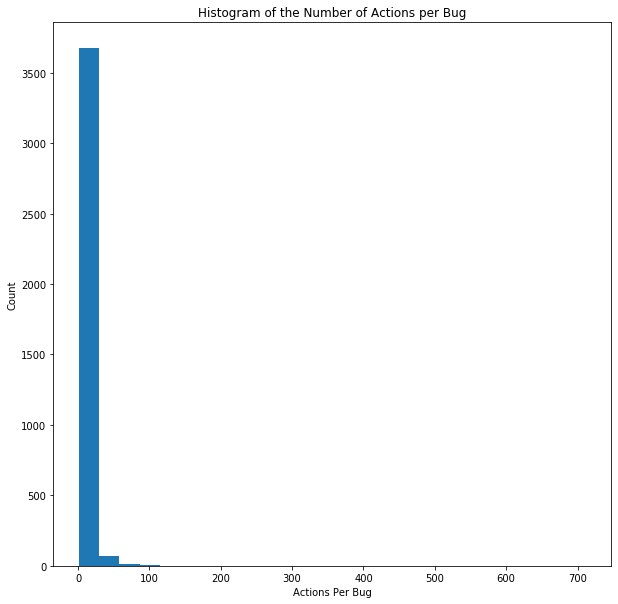

In [0]:
# Create a pivot table of the number of bug actions for each bug
bugID_pivot = pd.pivot_table(ticket_data,values = 'BugActionID',index = 'BugID',aggfunc = 'count').sort_values('BugActionID', ascending = False)

# Histogram of the number of bug actions 
plt.figure(figsize =(10,10))
plt.hist(bugID_pivot.BugActionID, bins = 25)
plt.ylabel('Count')
plt.xlabel('Actions Per Bug')
plt.title('Histogram of the Number of Actions per Bug')
plt.show()

In [0]:
bugID_pivot.sort_values('BugActionID')

,BugActionID
BugID,
505775,1
505769,1
506579,1
505777,1
506016,1
...,...
508878,96
508608,97
508313,99


In [0]:
ticket_data[ticket_data.BugID==444327]

,Unnamed: 0,BugActionID,BugID,ActionUserID,ActionTime,AssignedID,Notes,StatusID,PriorityID,BAContactID,UpdateType,ResolutionID,ClientTouched,CodeChanged,ClientEmailed,ClientPhoned,UserDepartment,UserPosition,NextBugActionID,LastTouchPrevToCloseID,OpenAfterCloseID,NextCloseConfirmedID,RawHours,BusinessHours,LastCloseID,ActionOrder,RedirectStatus,Title,Directory,ProductID,ReportedID,Description,compid,contactid,Originated,KBArticleID,CurrentResolutionID,OpenedTime,LastBugActionID,WasLow,WasAssignedToDev,LastBugActionStatus,NumBugActions,LastContact,WasEscalatedPastRepLevel,WorkspaceID,Summary,ClientTemp,MajorityPriorityID,SupportFailbyDev,SupportFailConfirm,Classification,HighestPriorityID,owner,IsEFP,LastRedirectStatus,ChangeDateTime,HistorySummary,HistoryClientTemp,UserID,ClosestBugActionID,ArticleID,KBTitle,NumUses,NumTimesEscalated,DefaultPriorityID,PackageID,KBProductID,Active,UserFriendlyDesc,SalesProductGroupID,DefaultClassification,PriorityID_Int,clean_notes,tokenized_notes,trunc_tokenized_notes,note_length_notrunc,note_length_trunc


It looks like the majority of bugs have very few actions. What is the average?

In [0]:
#Calculate average number of actions/bug
print(np.mean(bugID_pivot.BugActionID))

7.024144335367471


Clearly, most of the time there is only one action per bug, but what do the notes look like for these?

In [0]:
stop = 0
stop_threshold = 10
for index,note in enumerate(ticket_data.Notes[ticket_data.BugID.isin(list(bugID_pivot[bugID_pivot.BugActionID ==1].index))]):
  print('Note #%i:\n%s\n'%(index + 1,note))
  stop += 1
  if stop >= stop_threshold:
    break

Note #1:
(Created)

Note #2:
(Created)

Note #3:
(Created)

Note #4:
(Created)

Note #5:
(Created)

Note #6:
(Created)

Note #7:
(Created)

Note #8:
(Created)

Note #9:
(Created)

Note #10:
(Created)



### D.1.3 Categorical Features

In [0]:
ticket_data.columns

Index(['Unnamed: 0', 'BugActionID', 'BugID', 'ActionUserID', 'ActionTime',
       'AssignedID', 'Notes', 'StatusID', 'PriorityID', 'BAContactID',
       'UpdateType', 'ResolutionID', 'ClientTouched', 'CodeChanged',
       'ClientEmailed', 'ClientPhoned', 'UserDepartment', 'UserPosition',
       'NextBugActionID', 'LastTouchPrevToCloseID', 'OpenAfterCloseID',
       'NextCloseConfirmedID', 'RawHours', 'BusinessHours', 'LastCloseID',
       'ActionOrder', 'RedirectStatus', 'Title', 'Directory', 'ProductID',
       'ReportedID', 'Description', 'compid', 'contactid', 'Originated',
       'KBArticleID', 'CurrentResolutionID', 'OpenedTime', 'LastBugActionID',
       'WasLow', 'WasAssignedToDev', 'LastBugActionStatus', 'NumBugActions',
       'LastContact', 'WasEscalatedPastRepLevel', 'WorkspaceID', 'Summary',
       'ClientTemp', 'MajorityPriorityID', 'SupportFailbyDev',
       'SupportFailConfirm', 'Classification', 'HighestPriorityID', 'owner',
       'IsEFP', 'LastRedirectStatus', 'Change